In [1]:
# Python imports
import sys, numpy as np
# Torch
import torch, torchvision, torch.nn as nn, torch.optim as optim
# Navigation MDP
import navigation_mdp as NvMDP
# RL utils
import rl.planning as Plan
import rl.policy as Policy
# Utils
from utils.utils import *
from utils.plotting import NavGridViewPlotter as NvPlotter
# Matplotlib
from matplotlib import cm as cm, pyplot as plt, colors as mplotcolors
%load_ext autoreload
%autoreload 2

In [2]:
# dir(torchvision.datasets)

In [3]:
cifar = torchvision.datasets.CIFAR100(root="../datasets/", download=True)
X, y = cifar.data, np.asarray(cifar.targets)
classes = np.unique(y)
n_classes = len(classes)

print(X.shape, y.shape)

def sample_image(X, y, y_q):
    x_q = X[y == y_q]
    return x_q[np.random.randint(0, len(x_q))]

Files already downloaded and verified
(50000, 32, 32, 3) (50000,)


In [4]:
cifar.classes.index("house"), cifar.classes.index("skyscraper"), cifar.classes.index("road")

(37, 76, 68)

## Gridworld 5x5

**sanity check**

In [5]:
np.random.seed(5)
# Specify state space
S = NvMDP.state.DiscreteStateSpace(5,5)
goal = (0,0)

# Attach classes
S.sample_and_attach_classes([37, 76, 68], [0.2, 0.3, 0.5])
S.override_classes_by_loc([goal], [68])
# Attach features
S.attach_features(NvMDP.features.FeatureClassImageSampler(S, lambda x: sample_image(X, y, x)))
# Attach rewards
S.attach_rewards(NvMDP.reward.RewardStateScalar(S, loc_to_reward_dict={goal: 10}, class_id_to_reward_dict={
    37: 0, 76: 0, 68: 0}, default=0))
R = S.rewards()
# Specify dynamics
T = NvMDP.dynamics.XYDynamics(S, slip_prob=0.)
# Set goal
S.set_terminal_status_by_loc([goal])
# Value Iteration
VI = Plan.ValueIteration(S, R, T, verbose=True)
# VI.q_value_list(S[23], False)

In [6]:
log_Pi, V, Q, iterno = VI.run(100, Policy.Greedy, verbose=True, debug=False, eps=1e-6)
values = V.detach().numpy().round(2)

Running VI [  ] VI converged @ 2.


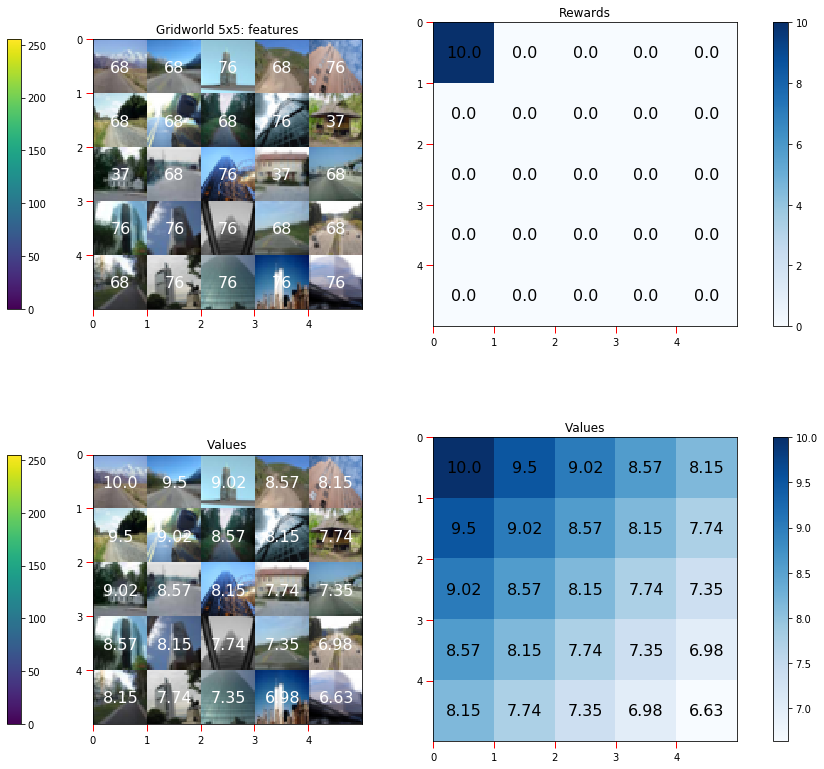

In [7]:
plt.figure(figsize=(14,14))
plt.subplot(2,2,1)
NvPlotter(S, R).plot_features(ann_col="white", title="Gridworld 5x5: features").colorbar(where="left", pad=1.)
plt.subplot(2,2,2)
NvPlotter(S, R).plot_rewards(cmap=cm.Blues, title="Rewards").colorbar(where="right", pad=0.5)
plt.subplot(2,2,3)
NvPlotter(S, R).plot_features(ann_col="white", ann=values, title="Values").colorbar(where="left", pad=1.)
plt.subplot(2,2,4)
NvPlotter(S, R).plot_array(values, cmap=cm.Blues, title="Values").colorbar(where="right", pad=0.5)

**Trying different reward function**

In [8]:
class_ids = NvMDP.class_.XYClassDistribution([
        
        [0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0],
        [0, 1, 1, 1, 0],
        [0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0]],
        marker_to_class_id = {
            1: 76,
            0: 68
        },
    )().flatten()

S.attach_classes(class_ids)
S.attach_features(NvMDP.features.FeatureClassImageSampler(S, lambda x: sample_image(X, y, x)))

In [9]:
S.attach_rewards(NvMDP.reward.RewardStateScalar(S, loc_to_reward_dict={goal: 0}, class_id_to_reward_dict={
    76: -1, 68: -0.1}, default=0))
R = S.rewards()

In [10]:
VI = Plan.ValueIteration(S, R, T, verbose=True)
log_Pi, V, Q, iterno = VI.run(100, Policy.Greedy, verbose=True, debug=False, eps=1e-6)
values = V.detach().numpy().round(2)

Running VI [  ] VI converged @ 8.


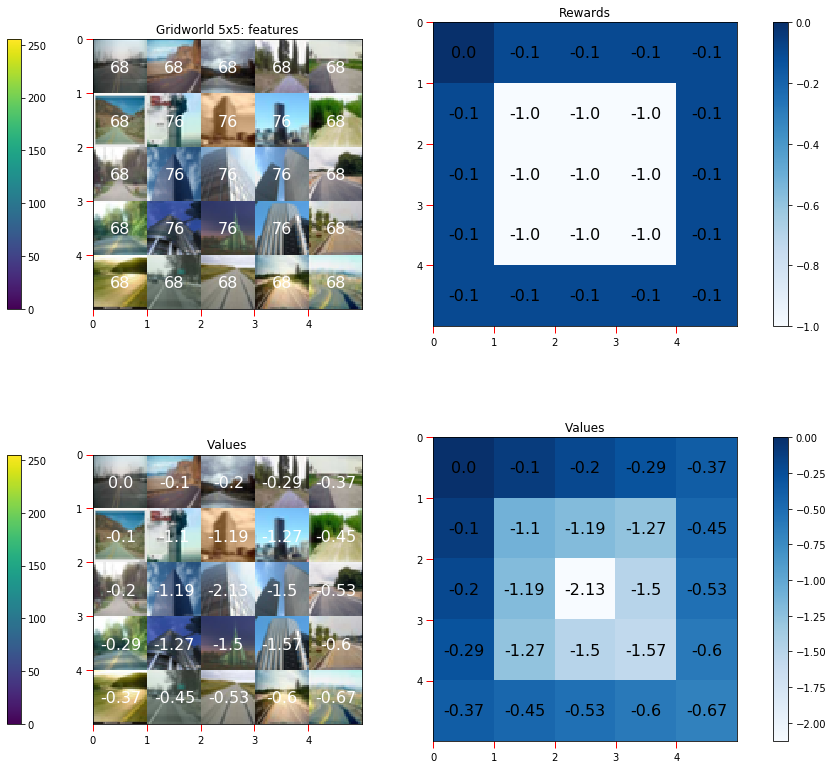

In [11]:
plt.figure(figsize=(14,14))
plt.subplot(2,2,1)
NvPlotter(S, R).plot_features(ann_col="white", title="Gridworld 5x5: features").colorbar(where="left", pad=1.)
plt.subplot(2,2,2)
NvPlotter(S, R).plot_rewards(cmap=cm.Blues, title="Rewards").colorbar(where="right", pad=0.5)
plt.subplot(2,2,3)
NvPlotter(S, R).plot_features(ann_col="white", ann=values, title="Values").colorbar(where="left", pad=1.)
plt.subplot(2,2,4)
NvPlotter(S, R).plot_array(values, cmap=cm.Blues, title="Values").colorbar(where="right", pad=0.5)